# Задание 11-12: Разведочный и кластерный анализ данных
*Выполнено студенткой группы ИММО-01-25 Чан Минь Ханг*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
import skfuzzy as fuzz
from fcmeans import FCM

from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap

import warnings
warnings.filterwarnings('ignore')

BOLD = '\033[1m'
END = '\033[0m'

Необходимо выполнить задания по разведочному анализу предлагаемых наборов данных в соответствии с предложенным вариантом. 

Необходимо выполнить задания по кластеризации предлагаемых наборов данных в соответствии с предложенным вариантом. 

Выполнить кластеризацию наборов данных, считая, что метки кластеров неизвестны, используя программные реализации иерархических алгоритмов кластеризации и итерационных алгоритмов кластеризации (k-means, fuzzy c-means, DBSCAN).

Определить оптимальное число кластеров, рассмотрев варианты кластеризации при числе кластеров от 2 до 10. 

Оценить качество кластеризации, используя различные показатели качества кластеризации, в том числе:
- индекс кластерного силуэта Silh и показатель на основе метода локтя elbow (в случае, когда неизвестны истинные метки классов (кластеров) объектов). 
- скорректированный индекс Рэнда ARI (в случае, когда известны истинные метки классов (кластеров) объектов). 

Выбрать лучший алгоритм кластеризации для своего набора данных. 

Выполнить визуализацию результатов кластеризации с помощью алгоритмов t-sne, UMAP, TriMAP и PacMAP, являющихся алгоритмами нелинейного снижения размерности, при различных сочетаниях значений их параметров: изобразить объекты разных кластеров маркерами разного цвета. Отметить центроиды кластеров, если алгоритм кластеризации их вычисляет.

Сделать выводы о принципах группирования объектов в кластеры и выполнить профилирование кластеров. 

In [2]:
def optimal_k(data):  
    inertias = []
    silhouette_scores = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        labels_kmeans = kmeans.labels_
        if len(set(labels_kmeans)) > 1:
            silhouette_scores.append(silhouette_score(data, labels_kmeans))
        else:
            silhouette_scores.append(0)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'o-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')
    plt.title(f'Метод локтя')
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score')
    plt.tight_layout()
    plt.show()
    
    k_elbow = np.argmin(np.diff(inertias)) + 2 if len(inertias) > 1 else 2
    k_silhouette = k_range[np.argmax(silhouette_scores)]
    
    print(f'Оптимальное число кластеров: {k_silhouette}')
    
    return k_silhouette

In [3]:
def visualize(data, result):
    labels = result['labels']
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels != -1]) if -1 in unique_labels else len(unique_labels)

    cmap = plt.cm.get_cmap('tab10', n_clusters)
    colors = cmap(np.arange(n_clusters))

    centers = result['centers']
    if centers is not None and len(centers) > 0:
        try:
            if centers.shape[1] == data.shape[1]:
                all_data = np.vstack([data, centers])
                center_indices = np.arange(len(data), len(data) + len(centers))
                data_labels = labels
                center_labels = np.arange(len(centers)) + (max(labels) + 1 if len(labels) > 0 else 0)
            else:
                all_data = data
                center_indices = None
                data_labels = labels
        except Exception as e:
            print(f"Warning: Could not process centers: {e}")
            all_data = data
            center_indices = None
            data_labels = labels
    else:
        all_data = data
        center_indices = None
        data_labels = labels
        
    legend_elements = []
    for i, label in enumerate(unique_labels):
        if label == -1:
            color = 'gray'
            label_text = 'Noise'
        else:
            color_idx = i % n_clusters if n_clusters > 0 else i
            color = cmap(color_idx)
            label_text = f'Cluster {label}'
        legend_elements.append(Patch(facecolor=color, edgecolor='k', label=label_text))

    reducers = {
        't-SNE': [
            {'n_components': 2, 'perplexity': 5, 'learning_rate': 200},
            {'n_components': 2, 'perplexity': 15, 'learning_rate': 200},
            {'n_components': 2, 'perplexity': 30, 'learning_rate': 200}
        ],
        'UMAP': [
            {'n_components': 2, 'n_neighbors': 5, 'min_dist': 0.1},
            {'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.1},
            {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0.1}
        ],
        'TriMAP': [
            {'n_dims': 2, 'n_inliers': 10, 'n_outliers': 5},
            {'n_dims': 2, 'n_inliers': 20, 'n_outliers': 10},
            {'n_dims': 2, 'n_inliers': 30, 'n_outliers': 15}
        ],
        'PaCMAP': [
            {'n_components': 2, 'n_neighbors': 10, 'MN_ratio': 0.5, 'FP_ratio': 2.0},
            {'n_components': 2, 'n_neighbors': 20, 'MN_ratio': 0.5, 'FP_ratio': 2.0},
            {'n_components': 2, 'n_neighbors': 10, 'MN_ratio': 0.8, 'FP_ratio': 2.0}
        ]
    }
    
    for reducer_name, param_list in reducers.items():
        fig, axes = plt.subplots(1, len(param_list), figsize=(5*len(param_list), 5))
        if len(param_list) == 1:
            axes = [axes]
        
        fig.suptitle(reducer_name, fontsize=14, fontweight='bold')
        
        for ax_idx, params in enumerate(param_list):
            try:
                if reducer_name == 't-SNE':
                    reducer = TSNE(random_state=42, **params)
                    embedding = reducer.fit_transform(all_data)
                    
                elif reducer_name == 'UMAP':
                    reducer = umap.UMAP(random_state=42, **params)
                    embedding = reducer.fit_transform(all_data)
                    
                elif reducer_name == 'TriMAP':
                    reducer = trimap.TRIMAP(**params)
                    embedding = reducer.fit_transform(all_data)
                    
                elif reducer_name == 'PaCMAP':
                    reducer = pacmap.PaCMAP(random_state=42, **params)
                    embedding = reducer.fit_transform(all_data)
                else:
                    continue
                
                ax = axes[ax_idx]
                
                # Разделяем embedding на данные и центроиды
                if center_indices is not None:
                    data_embedding = embedding[:len(data)]
                    centers_embedding = embedding[center_indices]
                else:
                    data_embedding = embedding
                    centers_embedding = None
                
                # Визуализируем исходные точки данных
                for i, label in enumerate(unique_labels):
                    if label == -1:  # Для DBSCAN noise points
                        mask = (data_labels == label)
                        if np.any(mask) and len(mask) == len(data_embedding):
                            ax.scatter(data_embedding[mask, 0], data_embedding[mask, 1], 
                                      c='gray', alpha=0.5, s=20, marker='x')
                    else:
                        mask = (data_labels == label)
                        if np.any(mask) and len(mask) == len(data_embedding):
                            color_idx = i % n_clusters if n_clusters > 0 else i
                            ax.scatter(data_embedding[mask, 0], data_embedding[mask, 1], 
                                      color=cmap(color_idx), alpha=0.7, s=30)
                
                # Отмечаем центроиды, если они есть
                if centers_embedding is not None and len(centers_embedding) > 0:
                    ax.scatter(centers_embedding[:, 0], centers_embedding[:, 1],
                              c='red', s=200, marker='*', edgecolors='black', linewidth=2, 
                              label='Centroids', zorder=5)
                
                ax.set_title(params, fontsize=10)
                ax.set_xlabel('Component 1')
                ax.set_ylabel('Component 2')
                ax.grid(True, alpha=0.3)
                
#                 if ax_idx == 0:
#                     if centers_embedding is not None and len(centers_embedding) > 0:
#                         legend_elements.append(Patch(facecolor='red', edgecolor='black', 
#                                                    label='Centroids'))
#                     ax.legend(handles=legend_elements, loc='upper left', 
#                             bbox_to_anchor=(1.05, 1), fontsize=8)
            
            except Exception as e:
                print(f"Ошибка при выполнении {reducer_name} с параметрами {params}: {e}")
                ax = axes[ax_idx]
                ax.text(0.5, 0.5, f"Error:\n{str(e)[:50]}...", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{reducer_name} - Error", fontsize=10)

        plt.tight_layout()
        plt.show()


In [4]:
def profiling(data, result):
    labels = result['labels']
    cluster_centers = result['centers']
    
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    
    profiled_data = data.copy()
    profiled_data['Cluster'] = labels

    cluster_stats = profiled_data.groupby('Cluster').agg(['mean', 'std', 'count'])
    
    cluster_sizes = profiled_data['Cluster'].value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        print(f"\tКластер {cluster}: {size} объектов ({size/len(data)*100:.1f}%)")

In [5]:
def clustering(data, k, true_labels=None):
    results = {}
    profiles = {}
    
    algorithms = ['Hierarchical',
                  'k-means', 'fuzzy c-means', 'DBSCAN']
    
    for algorithm in algorithms:
        print(f"\n{algorithm}:")
        centers = None
        
        if algorithm == 'Hierarchical':
            linkage_matrix = linkage(data, method='ward')
            labels = fcluster(linkage_matrix, k, criterion='maxclust')
            
            plt.figure(figsize=(10,5))
            dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
            plt.show()

        elif algorithm == 'k-means':
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit_predict(data)
            labels = km.labels_
            centers = km.cluster_centers_
            
        elif algorithm == 'fuzzy c-means':
            fcm = FCM(n_clusters=k)
            fcm.fit(data)
            labels = fcm.predict(data)
            centers = fcm.centers

        elif algorithm == 'DBSCAN':
            eps_values = [0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
            best_silhouette = -1
            best_labels = None
            
            for eps in eps_values:
                db = DBSCAN(eps=eps, min_samples=5)
                db.fit_predict(data)
                current_labels = db.labels_
                n_clusters = len(set(current_labels)) - (1 if -1 in current_labels else 0)
                
                if n_clusters > 1:
                    silhouette = silhouette_score(data[labels != -1], current_labels[labels != -1]) \
                                if len(np.unique(current_labels[current_labels != -1])) > 1 else -1
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_labels = current_labels
            
            labels = best_labels if best_labels is not None else DBSCAN(eps=0.5, min_samples=5).fit_predict(data)
        
        n_clusters = len(np.unique(labels))
        print(f"\tКоличество кластеров: {n_clusters}")
        print(f"\tМетки кластеров: {np.unique(labels)}")
        
        if n_clusters > 1 and n_clusters < len(data):
            silhouette = silhouette_score(data, labels)
            print(f"\tSilhouette Score: {silhouette:.4f}")
        else:
            silhouette = -1
#             print("\tНедостаточно кластеров для оценки silhouette score")
        
        if true_labels is not None:
            ari = adjusted_rand_score(true_labels, labels)
            print(f"\tAdjusted Rand Index: {ari:.4f}")
        else:
            ari = None
        
        results[algorithm] = {
            'n_clusters': n_clusters,
            'labels': labels,
            'centers': centers,
            'silhouette': silhouette,
            'ari': ari
        }
                
    print(BOLD + "\nСравнение результатов" + END)
    comparison_df = pd.DataFrame({
        'Algorithm': results.keys(),
        'N_Clusters': [results[algorithm]['n_clusters'] for algorithm in results],
        'Silhouette': [results[algorithm]['silhouette'] for algorithm in results],
        'ARI': [results[algorithm]['ari'] if results[algorithm]['ari'] is not None else np.nan 
                for algorithm in results]
    })
    print(comparison_df.sort_values(by='Silhouette', ascending=False))
        
#     if true_labels is not None:
#         best_algorithm = max(results.keys(), 
#                              key=lambda x: results[x]['ari'] 
#                              if results[x]['ari'] is not None else -1)
#         print(f"\nЛучший алгоритм (по ARI): {best_algorithm}")
#     else:
#         best_algorithm = max(results.keys(), 
#                              key=lambda x: results[x]['silhouette'])
#         print(f"\nЛучший алгоритм (по Silhouette): {best_algorithm}")
        
    best_algorithm = max(results.keys(), key=lambda x: results[x]['silhouette'])
    print(BOLD + f"\nЛучший алгоритм: {best_algorithm}" + END)
    
    profiling(data, results[best_algorithm])
    visualize(data, results[best_algorithm])

    return results

## Набор данных с известными метками классов (кластеров) объектов
http://archive.ics.uci.edu/ml/datasets/University

In [6]:
university_data = pd.read_csv('university.csv')
university_data

,name,state,control,no_of_students,male:female_ratio,student:faculty_ratio,sat_verbal,sat_math,expenses,percent_financial_aid,...,percent_admittance,percent_enrolled,academics_scale,social_scale,quality_of_life_scale,academic_emphasis,location,colors,mascot,religious_backing
0,ADELPHI,NEWYORK,PRIVATE,0-5000,30:70,15:1,500.0,475.0,7000-10000,60.0,...,70.0,40.0,2.0,2.0,2.0,"business-administration, biology",NaN,NaN,NaN,NaN
1,ARIZONA-STATE,ARIZONA,STATE,20000+,50:50,20:1,450.0,500.0,0-4000,50.0,...,80.0,60.0,3.0,4.0,5.0,"business-education, engineering, accounting, f...",NaN,NaN,NaN,NaN
2,BOSTON-COLLEGE,MASSACHUSETTS,PRIVATE:ROMAN-CATHOLIC,0-5000,40:60,20:1,500.0,550.0,10000+,60.0,...,50.0,40.0,4.0,5.0,3.0,"economics, biology, english",SUBURBAN,NaN,NaN,NaN
3,BOSTON-UNIVERSITY,MASSACHUSETTS,PRIVATE,10000-15000,45:55,12:1,550.0,575.0,10000+,60.0,...,60.0,40.0,4.0,4.0,3.0,"business-administration, psychology, liberal-arts",URBAN,NaN,NaN,NaN
4,BROWN,RHODEISLAND,PRIVATE,0-5000,50:50,11:1,625.0,650.0,10000+,40.0,...,20.0,50.0,5.0,4.0,5.0,"biology, history, arts-sciences",URBAN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,ORAL-ROBERTS-UNIVERSITY,OKLAHOMA,PRIVATE,0-5000,1:1,11:1,463.0,490.0,0-4000,70.0,...,65.0,75.0,4.0,2.0,3.0,"business-administration, education, fine-and-p...",SUBURBAN,NaN,NaN,NaN
281,UNIVERSITY-OF-TULSA,OKLAHOMA,PRIVATE,0-5000,3:2,16:1,471.0,520.0,0-4000,75.0,...,85.0,65.0,4.0,4.0,4.0,"area-studies, business-administration, educati...",URBAN,NaN,NaN,NaN
282,CONNECTICUT-COLLEGE,CONNECTICUT,PRIVATE,0-5000,35:65,10:1,550.0,575.0,10000+,30.0,...,40.0,40.0,4.0,3.0,4.0,liberal-arts,SMALL-CITY,NaN,NaN,NaN
283,LEHIGH-UNIVERSITY,PENNSYLVANIA,PRIVATE,0-5000,75:25,10:1,550.0,650.0,7000-10000,45.0,...,50.0,40.0,4.0,4.0,2.0,"engineering, physical",SMALL-CITY,NaN,NaN,NaN


In [7]:
university_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   285 non-null    object 
 1   state                  285 non-null    object 
 2   control                282 non-null    object 
 3   no_of_students         285 non-null    object 
 4   male:female_ratio      285 non-null    object 
 5   student:faculty_ratio  263 non-null    object 
 6   sat_verbal             263 non-null    float64
 7   sat_math               263 non-null    float64
 8   expenses               285 non-null    object 
 9   percent_financial_aid  273 non-null    float64
 10  no_applicants          279 non-null    object 
 11  percent_admittance     280 non-null    float64
 12  percent_enrolled       281 non-null    float64
 13  academics_scale        277 non-null    float64
 14  social_scale           277 non-null    float64
 15  qualit

In [8]:
university_clean = university_data.copy()

for col in university_clean.columns:
    if university_clean[col].dtype == 'object':
        university_clean[col].fillna(university_clean[col].mode()[0], inplace=True)
    else:
        university_clean[col].fillna(university_clean[col].median(), inplace=True)

label_encoders = {}
for col in ['state', 'control', 'location', 'academic_emphasis']:
    if col in university_clean.columns:
        le = LabelEncoder()
        university_clean[col] = le.fit_transform(university_clean[col].astype(str))
        label_encoders[col] = le

def parse_range(value):
    if isinstance(value, str):
        if '+' in value:
            return float(value.replace('+', '')) + 5000
        elif '-' in value:
            parts = value.split('-')
            if len(parts) == 2:
                try:
                    return (float(parts[0]) + float(parts[1])) / 2
                except:
                    return np.nan
    return float(value)

for col in ['no_of_students', 'expenses', 'no_applicants']:
    if col in university_clean.columns:
        university_clean[col] = university_clean[col].apply(parse_range)

def parse_ratio(value):
    if isinstance(value, str):
        if ':' in value:
            parts = value.split(':')
            if len(parts) == 2:
                try:
                    return float(parts[0]) / float(parts[1])
                except:
                    return np.nan
    return float(value)

ratio_cols = ['male:female_ratio', 'student:faculty_ratio']
for col in ratio_cols:
    if col in university_clean.columns:
        university_clean[col] = university_clean[col].apply(parse_ratio)

for col in ['name', 'colors', 'mascot', 'religious_backing']:
    if col in university_clean.columns:
        university_clean = university_clean.drop(columns=[col])

university_clean = university_clean.dropna()

university_clean

,state,control,no_of_students,male:female_ratio,student:faculty_ratio,sat_verbal,sat_math,expenses,percent_financial_aid,no_applicants,percent_admittance,percent_enrolled,academics_scale,social_scale,quality_of_life_scale,academic_emphasis,location
0,24,1,2500.0,0.428571,15.0,500.0,475.0,8500.0,60.0,2000.0,70.0,40.0,2.0,2.0,2.0,56,3
1,1,4,25000.0,1.000000,20.0,450.0,500.0,2000.0,50.0,22000.0,80.0,60.0,3.0,4.0,5.0,78,3
2,15,2,2500.0,0.666667,20.0,500.0,550.0,15000.0,60.0,11500.0,50.0,40.0,4.0,5.0,3.0,86,2
3,15,1,12500.0,0.818182,12.0,550.0,575.0,15000.0,60.0,15000.0,60.0,40.0,4.0,4.0,3.0,74,3
4,30,1,2500.0,1.000000,11.0,625.0,650.0,15000.0,40.0,11500.0,20.0,50.0,5.0,4.0,5.0,46,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,27,1,2500.0,1.000000,11.0,463.0,490.0,2000.0,70.0,2000.0,65.0,75.0,4.0,2.0,3.0,59,2
281,27,1,2500.0,1.500000,16.0,471.0,520.0,2000.0,75.0,2000.0,85.0,65.0,4.0,4.0,4.0,20,3
282,4,1,2500.0,0.538462,10.0,550.0,575.0,15000.0,30.0,2000.0,40.0,40.0,4.0,3.0,4.0,149,0
283,29,1,2500.0,3.000000,10.0,550.0,650.0,8500.0,45.0,2000.0,50.0,40.0,4.0,4.0,2.0,121,0


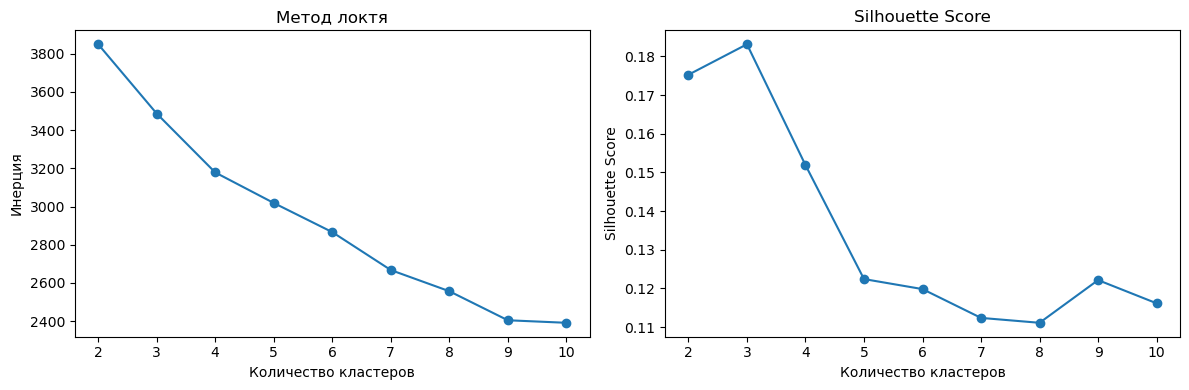

Оптимальное число кластеров: 3


In [9]:
university_scaled = StandardScaler().fit_transform(university_clean.drop('academics_scale', axis=1))

university_k = optimal_k(university_scaled)


Hierarchical:


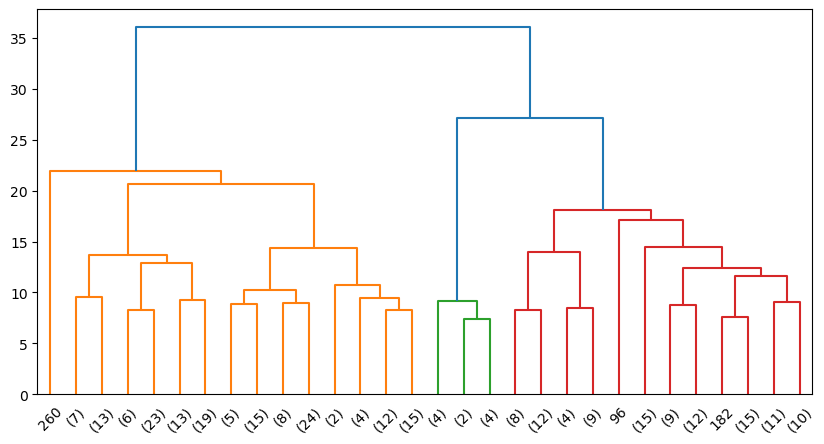

	Количество кластеров: 3
	Метки кластеров: [1 2 3]
	Silhouette Score: 0.1752
	Adjusted Rand Index: 0.0158

k-means:
	Количество кластеров: 3
	Метки кластеров: [0 1 2]
	Silhouette Score: 0.1832
	Adjusted Rand Index: 0.0183

fuzzy c-means:
	Количество кластеров: 2
	Метки кластеров: [0 2]
	Silhouette Score: 0.1657
	Adjusted Rand Index: 0.0220

DBSCAN:
	Количество кластеров: 1
	Метки кластеров: [-1]
	Adjusted Rand Index: 0.0000

Сравнение результатов
       Algorithm  N_Clusters  Silhouette       ARI
1        k-means           3    0.183162  0.018286
0   Hierarchical           3    0.175201  0.015759
2  fuzzy c-means           2    0.165711  0.022048
3         DBSCAN           1   -1.000000  0.000000

Лучший алгоритм: k-means
	Кластер 0: 166 объектов (58.5%)
	Кластер 1: 108 объектов (38.0%)
	Кластер 2: 10 объектов (3.5%)


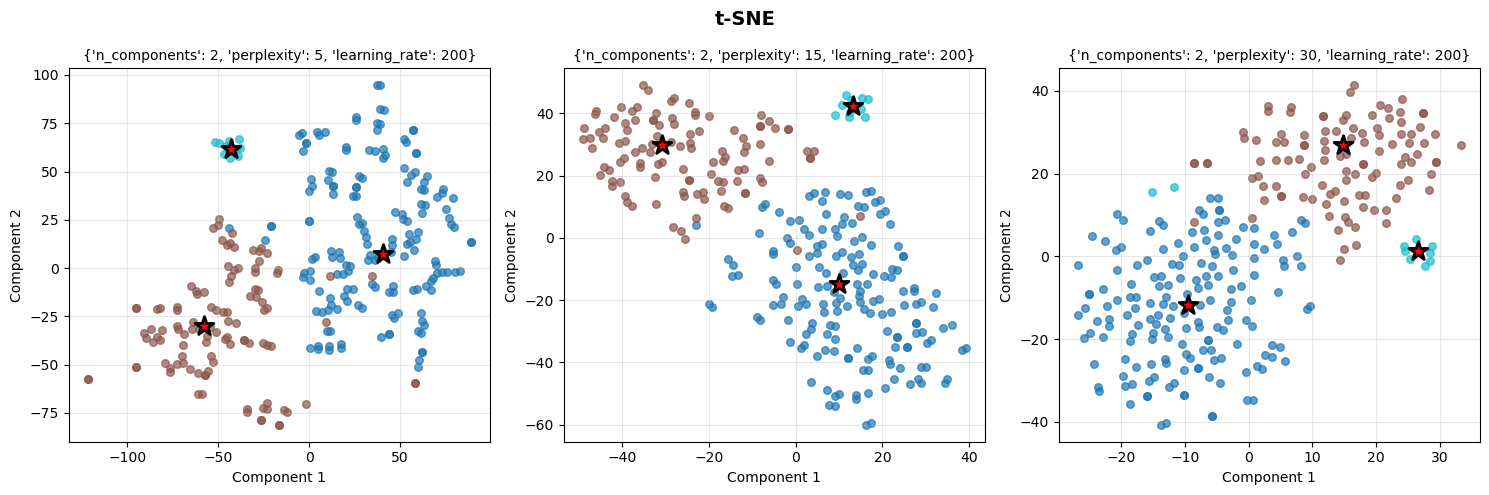

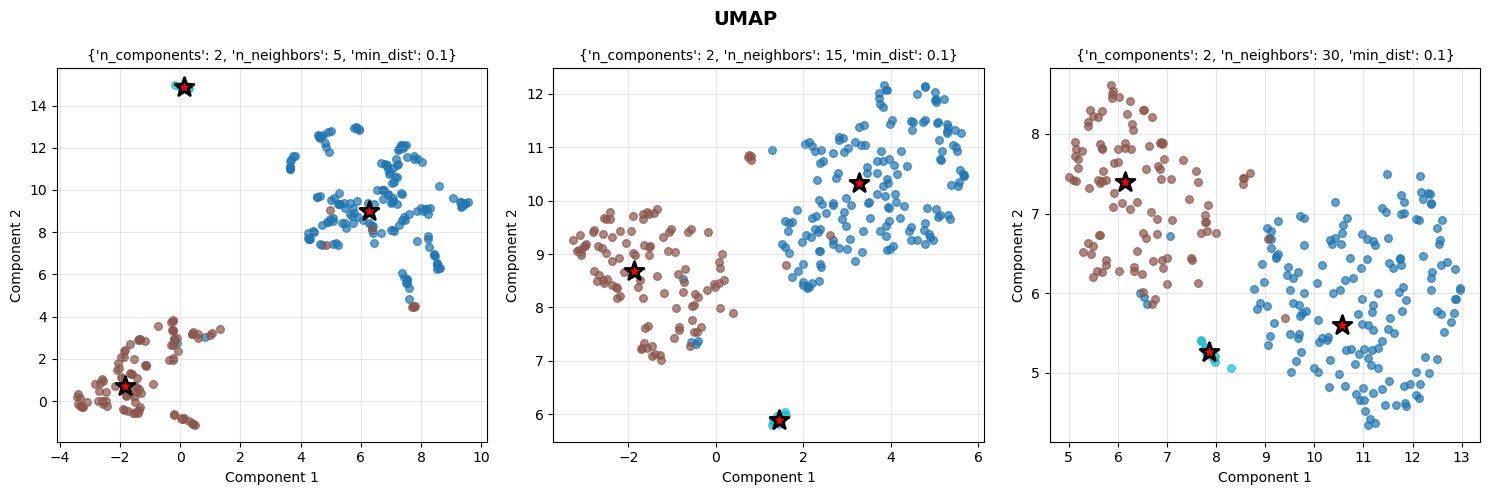

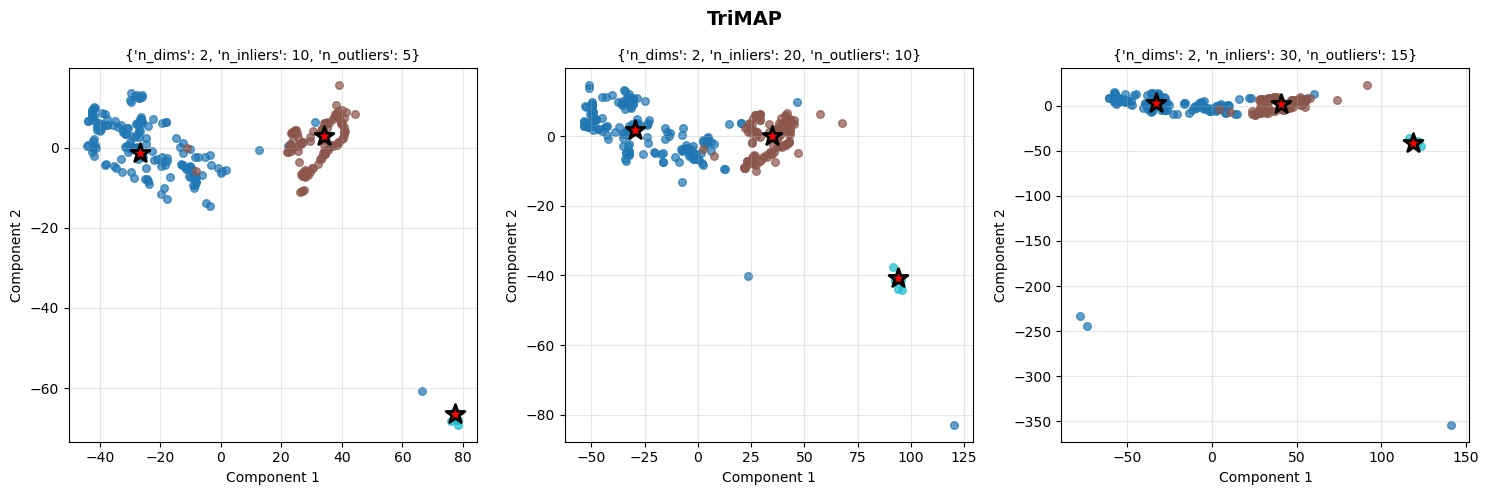

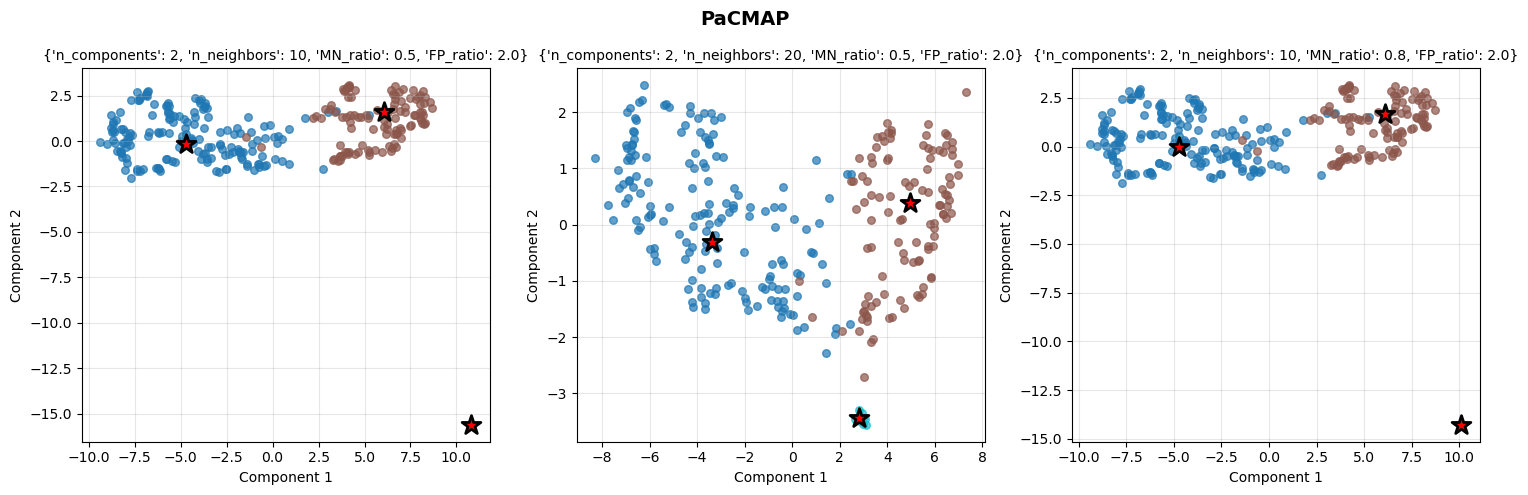

In [10]:
university_results = clustering(university_scaled, university_k,
                                university_clean['academics_scale'])

## Набор данных с неизвестными метками классов (кластеров) объектов
https://www.kaggle.com/roshansharma/mall-customers-clustering-analysis https://github.com/sharmaroshan/Clustering-of-Mall-Customers

In [11]:
mall_data = pd.read_csv('Mall_Customers.csv')
mall_data

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [12]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


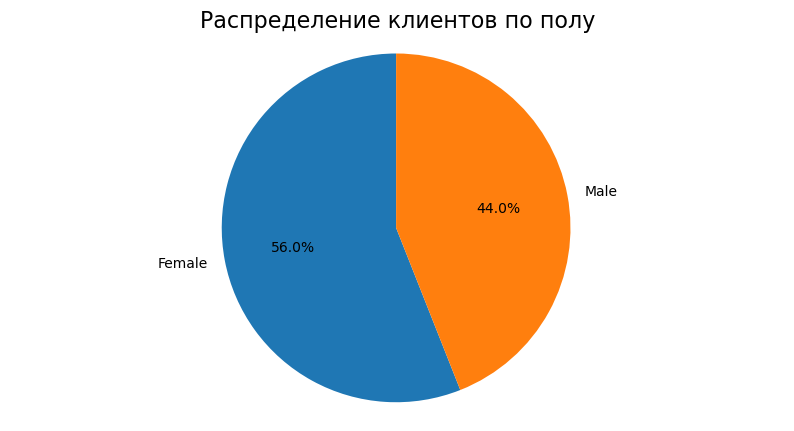

In [67]:
plt.figure(figsize=(10, 5))
genre_counts = mall_data['Genre'].value_counts()
plt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение клиентов по полу', fontsize=16)
plt.axis('equal')
plt.show()

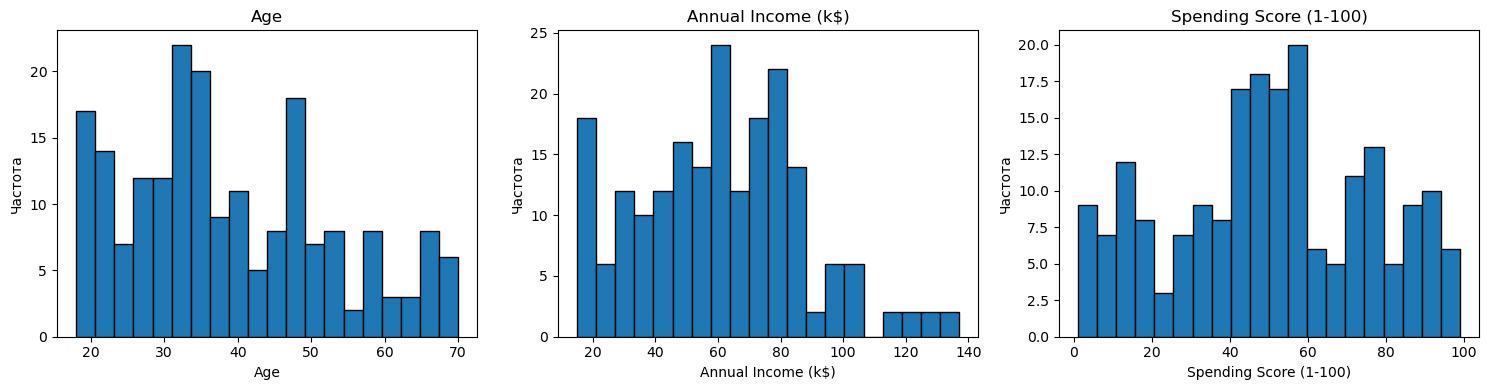

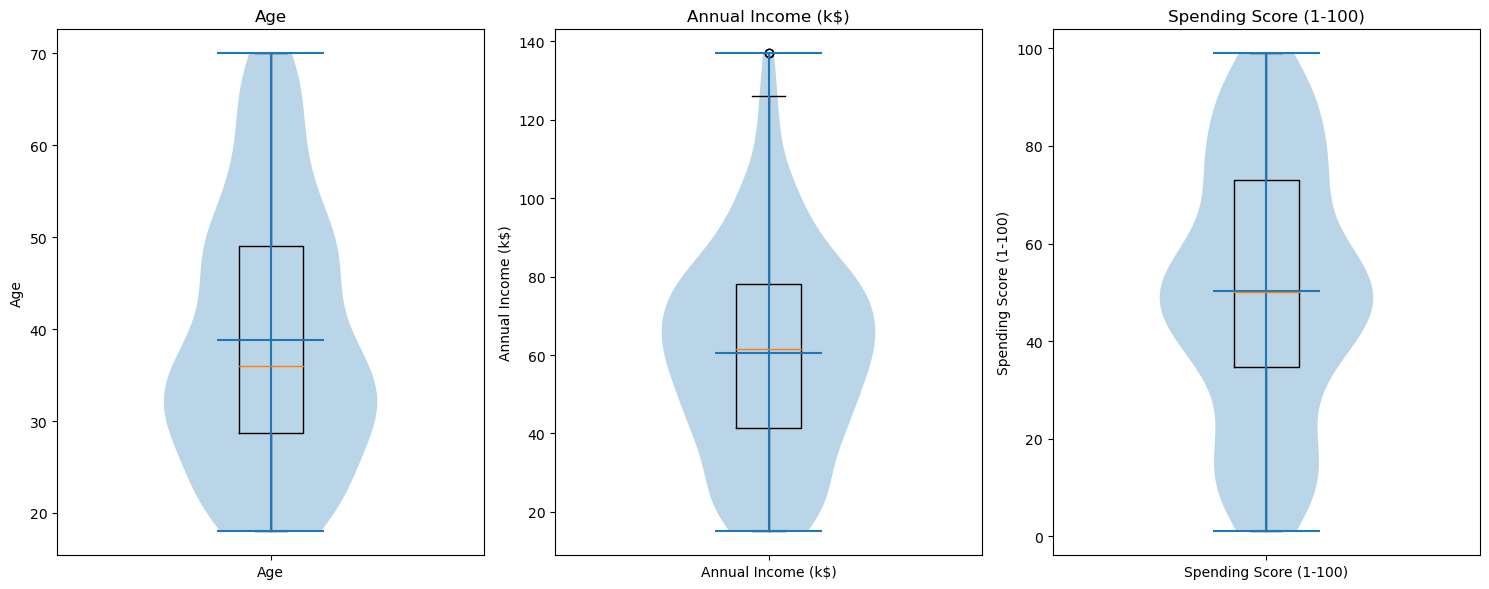

In [89]:
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
for idx, col in enumerate(numeric_cols):
    axes[idx].hist(mall_data[col], bins=20, edgecolor='black')
    axes[idx].set_title(col)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(mall_data[col])
    axes[idx].violinplot(mall_data[col], showmeans=True)
    axes[idx].set_title(col)
    axes[idx].set_ylabel(col)
    axes[idx].set_xticklabels([col])
plt.tight_layout()
plt.show()

Корреляционная матрица:
                             Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


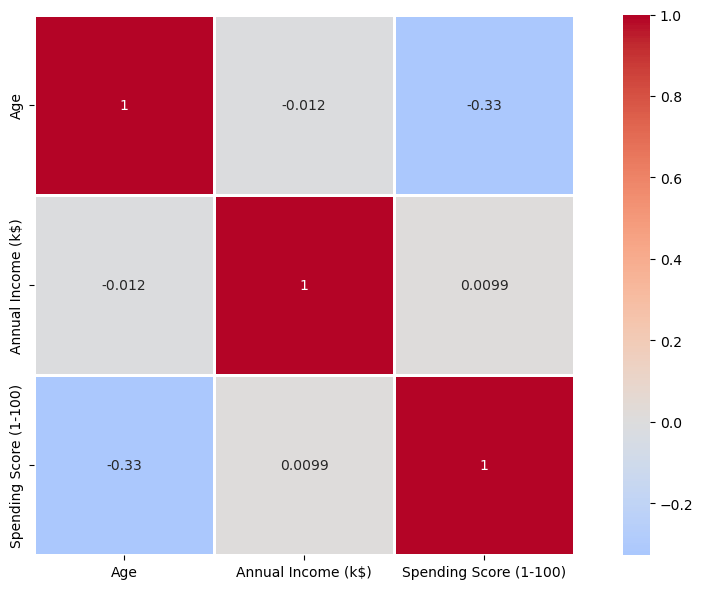

In [52]:
correlation_matrix = mall_data[numeric_cols].corr()

print("Корреляционная матрица:")
print(correlation_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.tight_layout()
plt.show()

In [68]:
# mall_clean = mall_data.drop('CustomerID', axis=1)
# mall_clean['Genre'] = LabelEncoder().fit_transform(mall_clean['Genre'])
mall_clean = mall_data[numeric_cols]
mall_clean

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


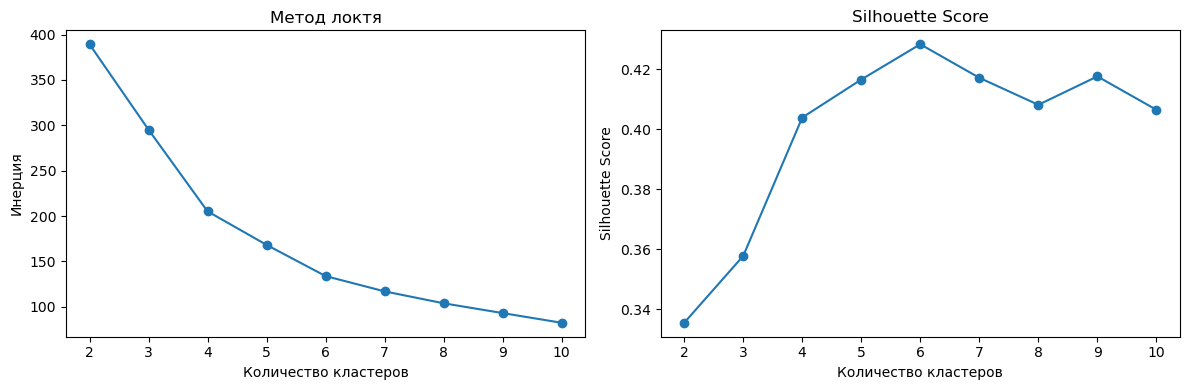

Оптимальное число кластеров: 6


In [15]:
mall_scaled = StandardScaler().fit_transform(mall_clean)

mall_k = optimal_k(mall_scaled)


Hierarchical:


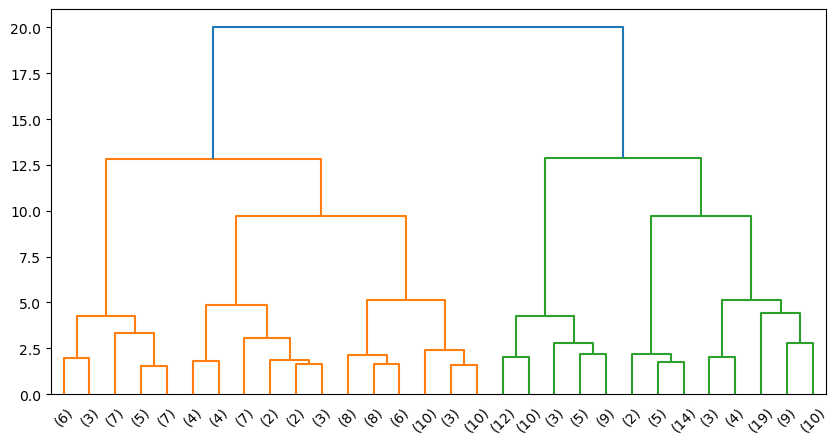

	Количество кластеров: 6
	Метки кластеров: [1 2 3 4 5 6]
	Silhouette Score: 0.4201

k-means:
	Количество кластеров: 6
	Метки кластеров: [0 1 2 3 4 5]
	Silhouette Score: 0.4284

fuzzy c-means:
	Количество кластеров: 6
	Метки кластеров: [0 1 2 3 4 5]
	Silhouette Score: 0.3806

DBSCAN:
	Количество кластеров: 7
	Метки кластеров: [-1  0  1  2  3  4  5]
	Silhouette Score: 0.1845

Сравнение результатов
       Algorithm  N_Clusters  Silhouette  ARI
1        k-means           6    0.428417  NaN
0   Hierarchical           6    0.420117  NaN
2  fuzzy c-means           6    0.380615  NaN
3         DBSCAN           7    0.184514  NaN

Лучший алгоритм: k-means
	Кластер 0: 45 объектов (22.5%)
	Кластер 1: 39 объектов (19.5%)
	Кластер 2: 33 объектов (16.5%)
	Кластер 3: 39 объектов (19.5%)
	Кластер 4: 23 объектов (11.5%)
	Кластер 5: 21 объектов (10.5%)


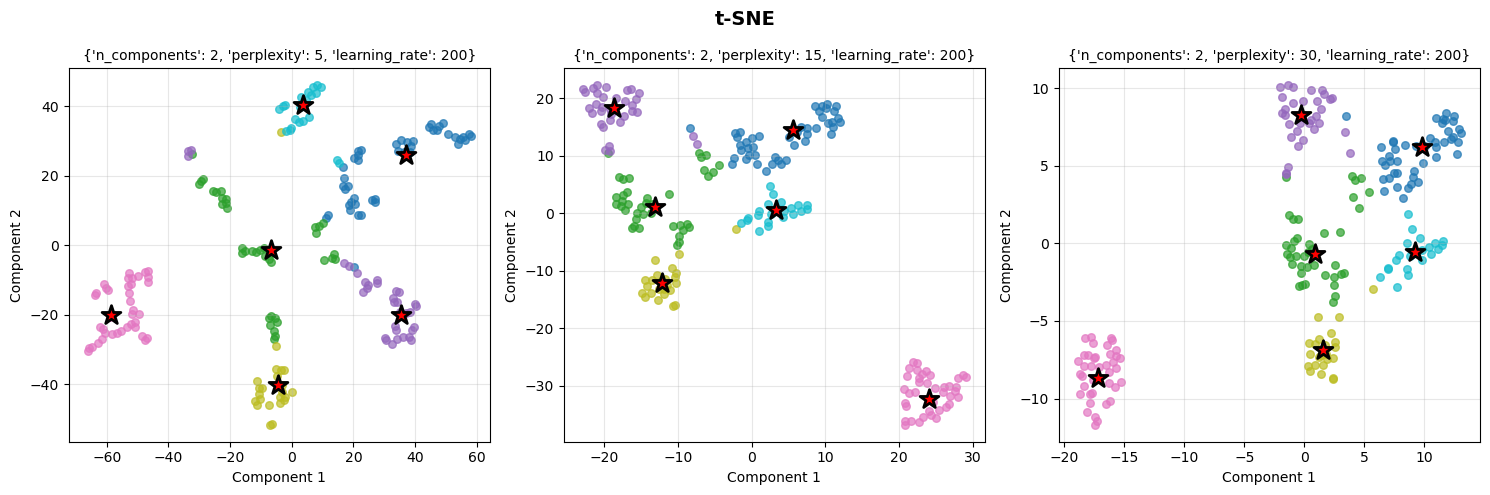

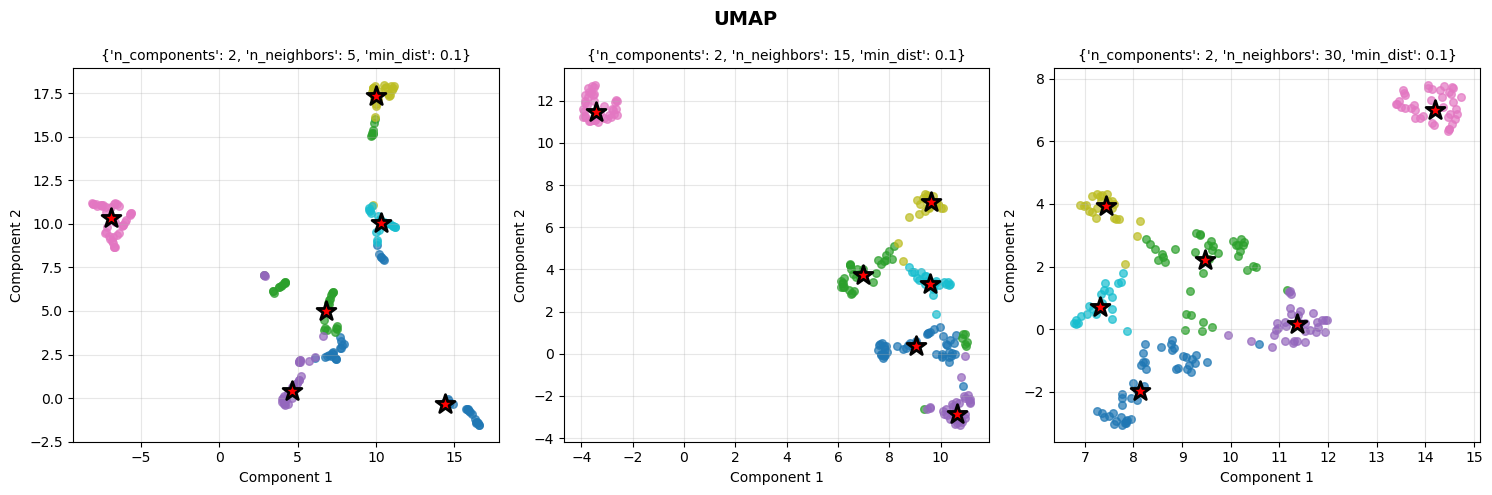

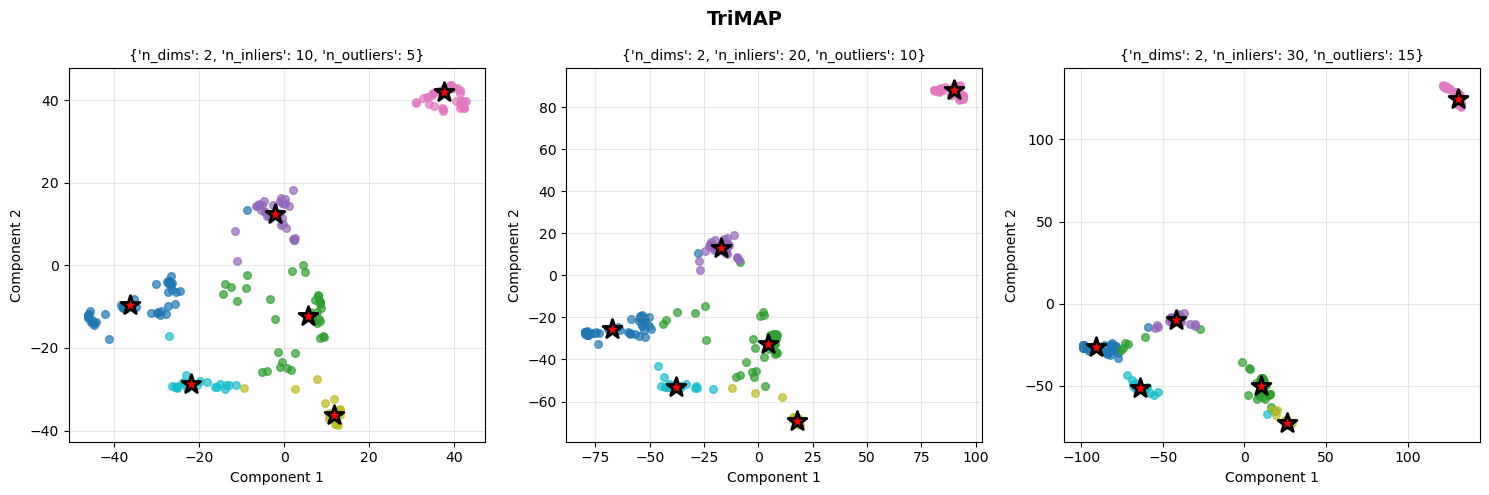

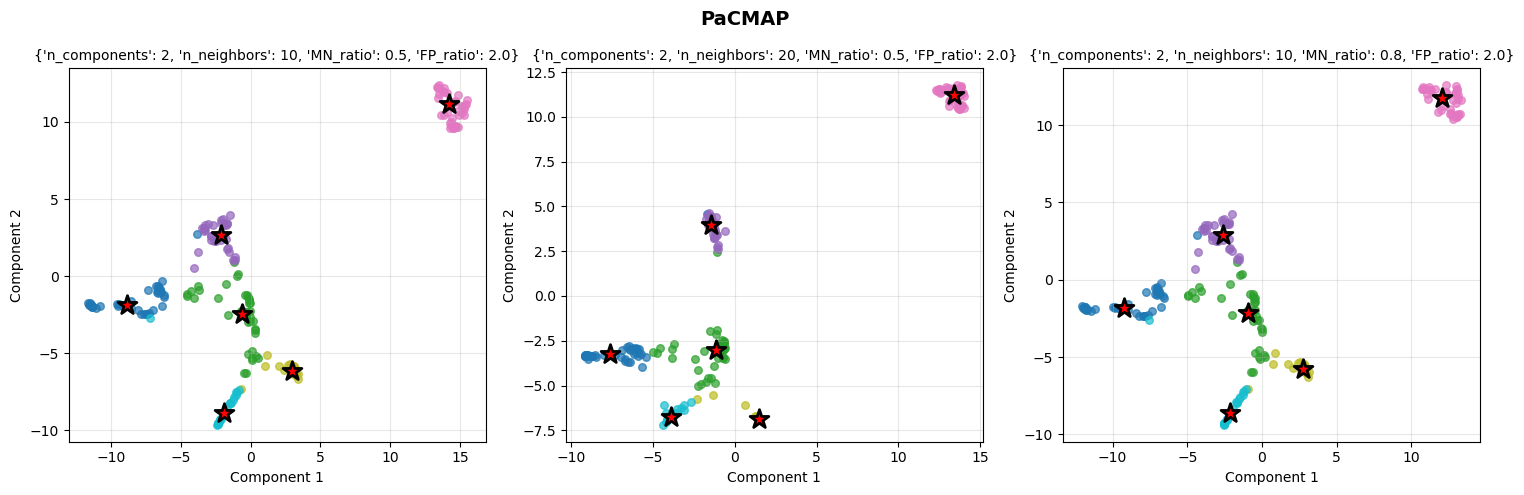

In [16]:
mall_results = clustering(mall_scaled, mall_k)

## Hабор данных мамонта

Выполнить кластеризацию набора данных mammoth.csv. Выполнить визуализацию результатов кластеризации с помощью алгоритмов t-sne, UMAP, TriMAP и PacMAP. 

In [17]:
mammoth_data = pd.read_csv('mammoth.csv')
mammoth_data

,x,y,z
0,58.823,228.407,79.843
1,59.197,228.642,77.478
2,58.734,228.931,78.515
3,59.043,228.693,78.571
4,59.223,228.667,78.611
...,...,...,...
999773,45.775,313.390,117.697
999774,54.707,323.795,-80.527
999775,53.756,324.630,-83.203
999776,49.131,319.816,-26.200


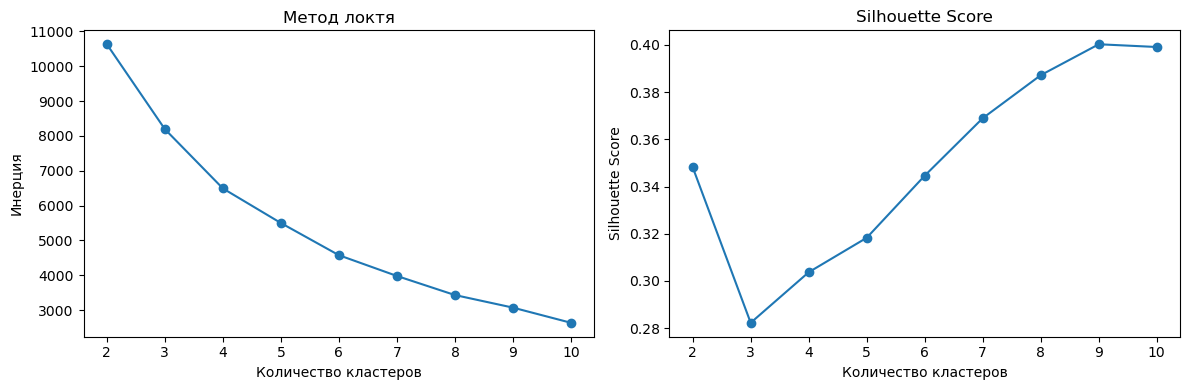

Оптимальное число кластеров: 9


In [19]:
mammoth_sample = mammoth_data.sample(n=5000, random_state=42).copy()

mammoth_scaled = StandardScaler().fit_transform(mammoth_sample)

mammoth_k = optimal_k(mammoth_scaled)


Hierarchical:


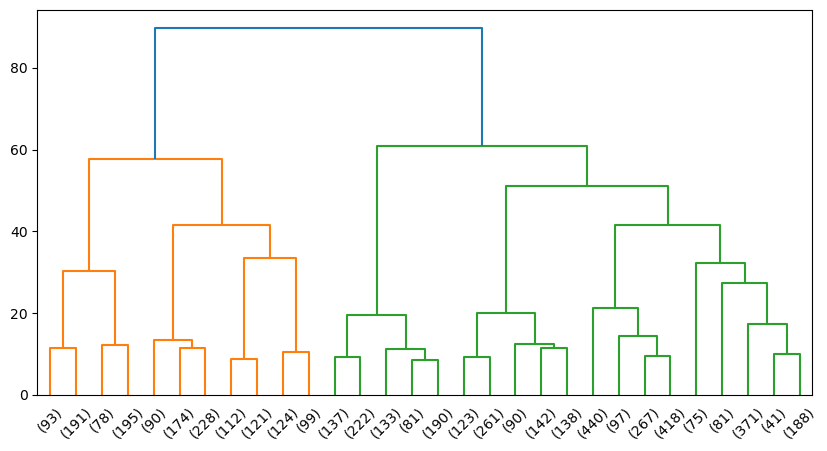

	Количество кластеров: 9
	Метки кластеров: [1 2 3 4 5 6 7 8 9]
	Silhouette Score: 0.3479

k-means:
	Количество кластеров: 9
	Метки кластеров: [0 1 2 3 4 5 6 7 8]
	Silhouette Score: 0.4003

fuzzy c-means:
	Количество кластеров: 9
	Метки кластеров: [0 1 2 3 4 5 6 7 8]
	Silhouette Score: 0.3031

DBSCAN:
	Количество кластеров: 9
	Метки кластеров: [-1  0  1  2  3  4  5  6  7]
	Silhouette Score: -0.1767

Сравнение результатов
       Algorithm  N_Clusters  Silhouette  ARI
1        k-means           9    0.400284  NaN
0   Hierarchical           9    0.347855  NaN
2  fuzzy c-means           9    0.303135  NaN
3         DBSCAN           9   -0.176738  NaN

Лучший алгоритм: k-means
	Кластер 0: 1378 объектов (27.6%)
	Кластер 1: 309 объектов (6.2%)
	Кластер 2: 905 объектов (18.1%)
	Кластер 3: 750 объектов (15.0%)
	Кластер 4: 338 объектов (6.8%)
	Кластер 5: 288 объектов (5.8%)
	Кластер 6: 683 объектов (13.7%)
	Кластер 7: 240 объектов (4.8%)
	Кластер 8: 109 объектов (2.2%)


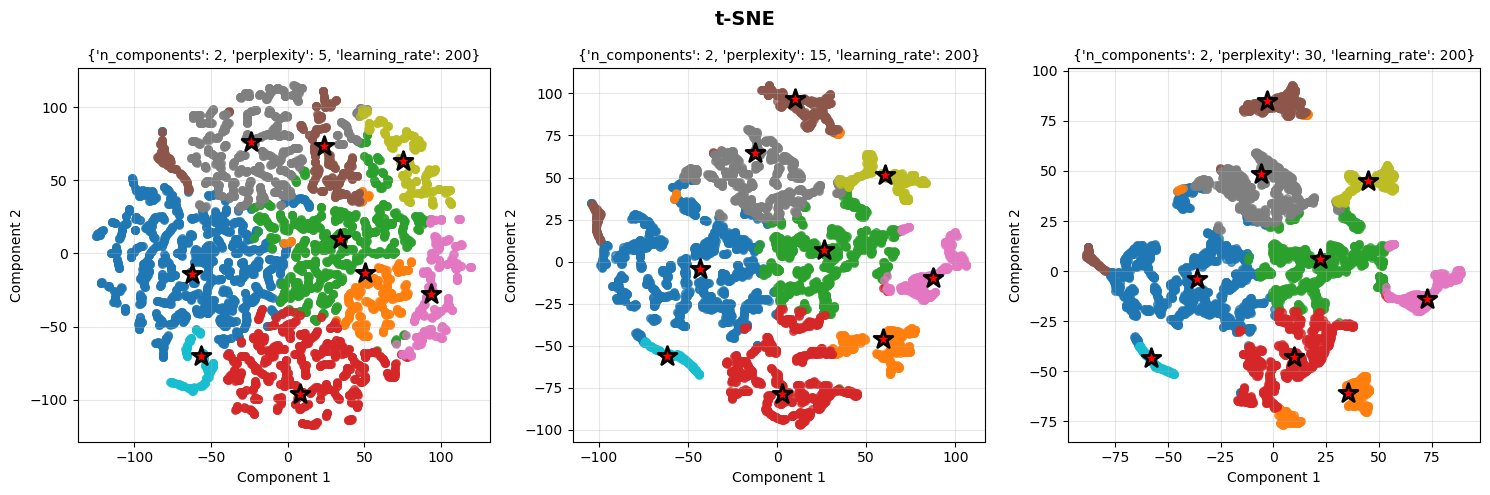

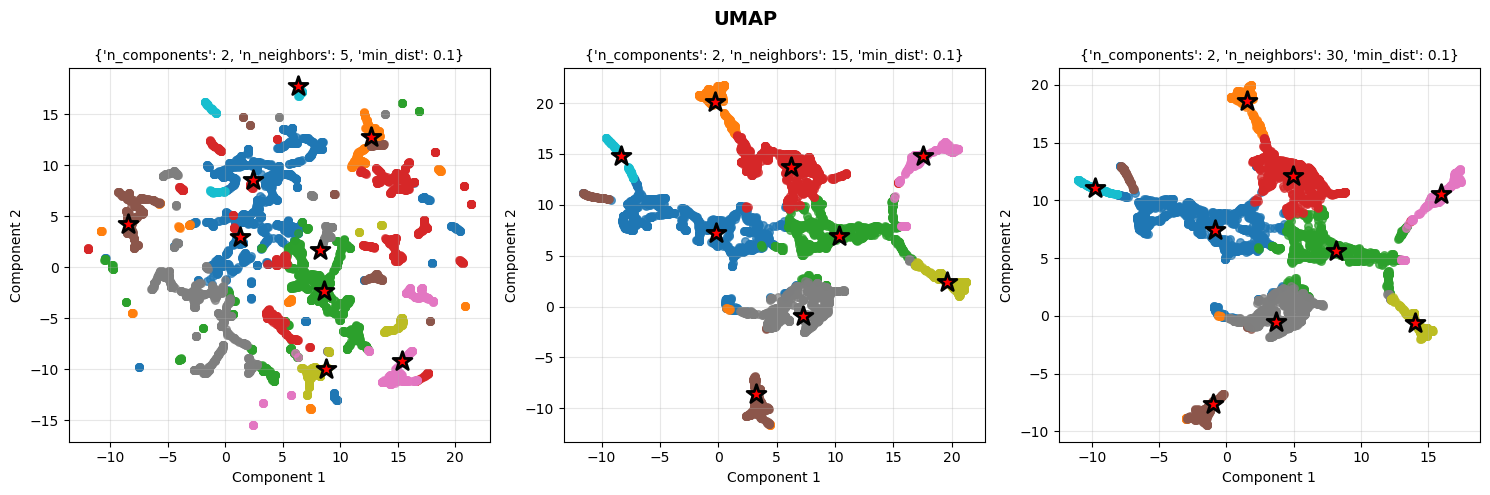

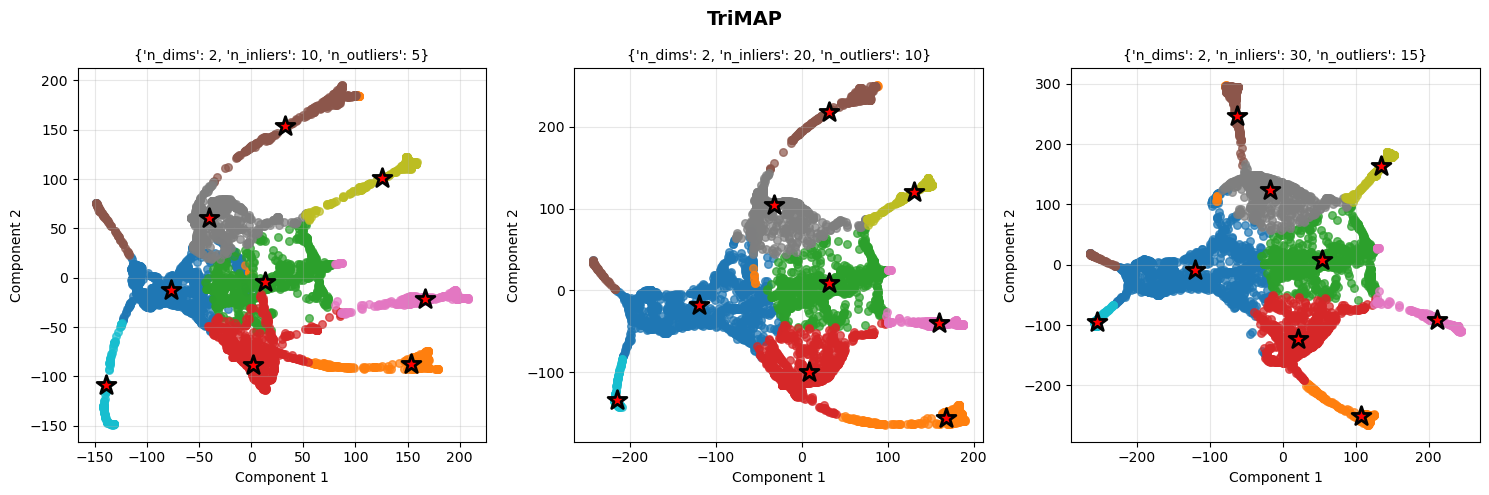

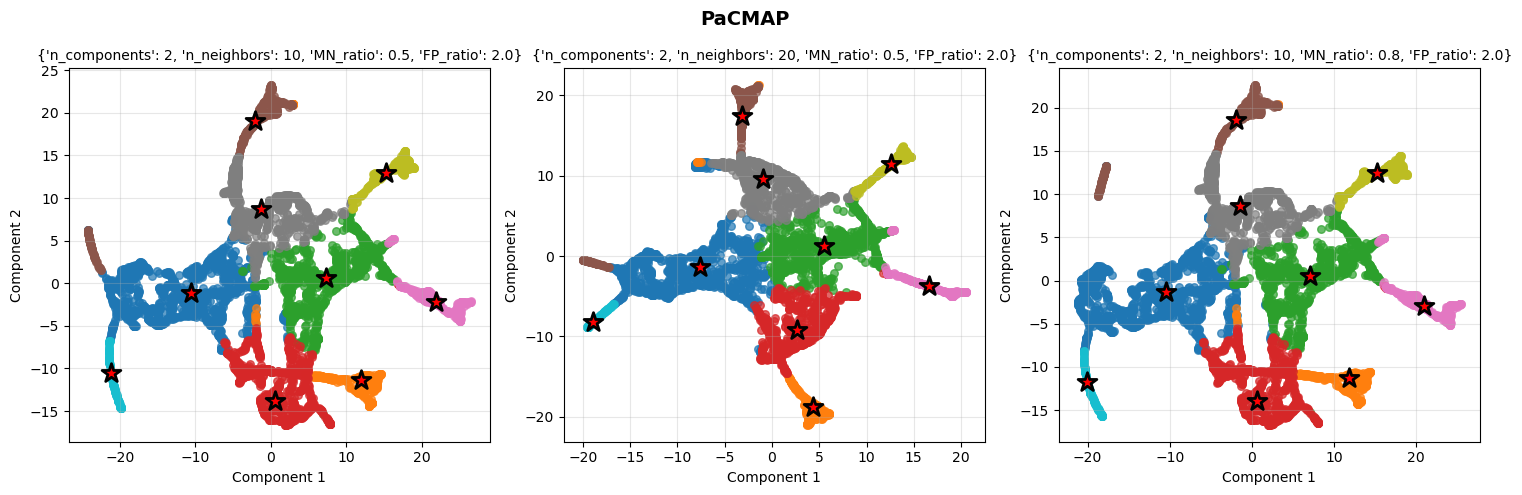

In [20]:
mammoth_results = clustering(mammoth_scaled, mammoth_k)